# K-Nearest Neighbors Homework Solutions
***
**Name**: $<$Xu Han$>$ 
***

This assignment is due on Moodle by **5pm on Friday January 26th**. Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. Your solutions to analysis questions should be done in Markdown directly below the associated question.  Remember that you are encouraged to discuss the problems with your instructors and classmates, but **you must write all code and solutions on your own**.  For a refresher on the course **Collaboration Policy** click [here](https://github.com/chrisketelsen/CSCI5622-Machine-Learning/blob/master/resources/syllabus.md#collaboration-policy)



## Overview 
***


In this homework you'll implement a K-Nearest Neighbor framework to take an image of a handwritten digit and predict which digit it corresponds to.  

<br>

![Samples of Handwritten Digits](wide_mnist.png "MNIST Digits")


<br>

This homework is designed to be pretty easy. If you're spending a ton of time on this assignment, then you are either:

- not prepared to take this course (i.e., if you're struggling with Python)
- seriously over-thinking the assignment
- trying to implement too much of KNN from scratch


Most of this assignment will be done by calling libraries that are already implemented for you. If you are implementing $n$-dimensional search or your own distance metrics, you are generating extra work for yourself and making yourself vulnerable to errors. 

Here are the rules: 

- Do **NOT** load or use any Python packages that are not available in Anaconda 3.6. 
- Some problems with code may be autograded.  If we provide a function or class API **do not** change it.
- Do not change the location of the data or data directory.  Use only relative paths to access the data. 

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline 

### [5 points] Problem 1
***

The class below will load and store the MNIST data.  Load the data and then report: 
- The number of examples in the training set 
- The number of examples in the test set 
- The number of pixels in each image. 

In [2]:
class Numbers:
    """
    Class to store MNIST data
    """
    def __init__(self, location):

        import pickle, gzip

        # load data from file 
        f = gzip.open(location, 'rb')
        train_set, valid_set, test_set = pickle.load(f)
        f.close()

        # store for use later  
        self.train_x, self.train_y = train_set
        self.test_x, self.test_y = valid_set
        
        #calculte the number of examples in the training and test set
        train_set_number = len(self.train_x)
        test_set_number = len(self.test_x)
        
        #calculate the number of pixels in each image
        pixels_number = self.train_x.shape[1]
        
        print("The number of examples in the training set is {:}".format(train_set_number))
        print("The number of examples in the test set is {:}".format(test_set_number))
        print("The number of pixels in each image is {:}".format(pixels_number))

In [7]:
data = Numbers("../data/mnist.pklz")

The number of examples in the training set is 50000
The number of examples in the test set is 10000
The number of pixels in each image is 784


### [30 points] Problem 2
***

The class below will perform K-Nearest Neighbor classification on our handwritten digit data. Your tasks are as follows:   

1. Modify the `label_counts` function to return a dictionary of frequencies corresponding to each label in the training set. 
1. Modify the `majority` function so that it returns the _label_ that appears most frequently in the $K$-nearest neighbors of the query point.  In the case that the maximum frequency occurs for two or more labels, return the one that appears most frequently in the entire training set. In the case that there is still a tie, break the tie in any way that you choose. 
1. Modify the `classify` function so that it finds the _indices_ of the $K$ closest training examples to the query point and then calls the `majority` function to return the predicted label. Almost all of the heavy lifting here will be done by the BallTree object from `sklearn.neighbors`, so you'll want to start out by reading the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html).  
1. Modify the `confusion_matrix` function to classify examples and record the results in a confusion matrix. You should construct the confusion matrix on your own.  Don't call any additional functions from sklearn to do it for you.

The class Knearest also implements an `accuracy` function which you will use in **Problem 3**.  You should not have to modify this function. 

We've given you unit tests down below based on the simple example worked out in lecture.  At first your code will fail all of them.  Do not move on to **Problem 3** until your code passes all of the unit tests. In addition, passing the unit tests does not guarantee that your implementation is robust and that you'll earn full points on this problem.  You should be designing your own additional tests as well. 

In [8]:
class Knearest:
    """
    kNN classifier
    """

    def __init__(self, X, y, k=5):
        """
        Creates a kNN instance

        :param x: Training data input
        :param y: Training data output
        :param k: The number of nearest points to consider in classification
        """
        
        from sklearn.neighbors import BallTree

        self._kdtree = BallTree(X)
        self._y = y
        self._k = k
        self._counts = self.label_counts()
        
    def label_counts(self):
        """
        Given the training labels, return a dictionary d where d[y] is  
        the number of times that label y appears in the training set. 
        """
        d = {}

        for ii in np.unique(self._y):
            d[ii] = np.count_nonzero(np.array(self._y) == ii)

        #print(d)
        #return dict({1:0, -1:0})
        return d

    def majority(self, neighbor_indices):
        """
        Given the indices of training examples, return the majority label. Break ties 
        by choosing the tied label that appears most often in the training data. 

        :param neighbor_indices: The indices of the k nearest neighbors
        """
        assert len(neighbor_indices) == self._k, "Did not get k neighbor indices"
        
        #calculate the frequency for each label within neighbor_indices
        neighbor_label_dict = {}
               
        for label in np.unique(self._y[neighbor_indices]):
            neighbor_label_dict[label] = np.count_nonzero(np.array(self._y[neighbor_indices]) == label)
        
        #print(neighbor_label_dict)
        #find max count
        max_count = max(list(neighbor_label_dict.values()))
        #print(max_count)
        
        #find label with max count
        majority_label_list = [] 
        
        for kk in neighbor_label_dict:
            if neighbor_label_dict[kk] == max_count:
                majority_label_list.append(kk)
        
        #print(majority_label_list)
        
        if len(majority_label_list) == 1:
        #there is only on label with max count
            #print(len(majority_label_list))
            #print(majority_label_list)
            return majority_label_list[0]
        else:
        #return the label that appears most frequently in the entire dataset
        #find the label with most frequency
            entire_max_label = {}
            entire_label = self.label_counts()
            for ll in majority_label_list:
                entire_max_label[ll] = entire_label[ll]
            
            entire_max_count = max(list(entire_max_label.values()))
            
            entire_majority_label_list = []
            for entire_kk in entire_max_label:
                if entire_max_label[entire_kk] == entire_max_count:
                    entire_majority_label_list.append(entire_kk)
            
            
            return entire_majority_label_list[0]
        
        
        #return self._y[neighbor_indices[0]]
    

    def classify(self, example):
        """
        Given an example, return the predicted label. 

        :param example: A representation of an example in the same
        format as a row of the training data
        """
        distances, indices = self._kdtree.query(example.reshape(1, -1), self._k)
        return self.majority(indices[0])


    def confusion_matrix(self, test_x, test_y):
        """
        Given a matrix of test examples and labels, compute the confusion
        matrix for the current classifier.  Should return a 2-dimensional
        numpy array of ints, C, where C[ii,jj] is the number of times an 
        example with true label ii was labeled as jj.

        :param test_x: test data 
        :param test_y: true test labels 
        """
        
        C = np.zeros((10,10), dtype=int)
        #count_test = 0
        for xx, yy in zip(test_x, test_y):
            pre_label = self.classify(xx)
            C[yy, pre_label] += 1
            
            #if pre_label != yy:
                #print('index:', count_test, 'actual label: ',yy, 'predicted label: ', pre_label)
            #count_test += 1
            
        #print("Confusion matrix is:")
        #print(C)
        
        return C 
            
    @staticmethod
    def accuracy(C):
        """
        Given a confusion matrix C, compute the accuracy of the underlying classifier.
        
        :param C: a confusion matrix 
        """
        
        return np.sum(C.diagonal()) / C.sum()
        

Here are the unit tests.  You don't need to modify them.  Simply execute the cell and observe the output. 

In [9]:
import unittest

class TestKnn(unittest.TestCase):
    def setUp(self):
        self.x = np.array([[2, 0], [4, 1], [6, 0], [1, 4], [2, 4], [2, 5], [4, 4], [0, 2], [3, 2], [4, 2], [5, 2], [5, 5]])
        self.y = np.array([+1, +1, +1, +1, +1, +1, +1, -1, -1, -1, -1, -1])
        self.knn = {}
        for ii in [1, 2, 3]:
            self.knn[ii] = Knearest(self.x, self.y, ii)

        self.queries = np.array([[1, 5], [0, 3], [6, 4]])
        
    def test0(self):
        """
        Test the label counter 
        """
        self.assertEqual(self.knn[1]._counts[-1], 5)
        self.assertEqual(self.knn[1]._counts[1], 7)

    def test1(self):
        """
        Test 1NN
        """
        self.assertEqual(self.knn[1].classify(self.queries[0]),  1)
        self.assertEqual(self.knn[1].classify(self.queries[1]), -1)
        self.assertEqual(self.knn[1].classify(self.queries[2]), -1)

    def test2(self):
        """
        Test 2NN
        """
        self.assertEqual(self.knn[2].classify(self.queries[0]),  1)
        self.assertEqual(self.knn[2].classify(self.queries[1]),  1)
        self.assertEqual(self.knn[2].classify(self.queries[2]),  1)

    def test3(self):
        """
        Test 3NN
        """
        self.assertEqual(self.knn[3].classify(self.queries[0]),  1)
        self.assertEqual(self.knn[3].classify(self.queries[1]),  1)
        self.assertEqual(self.knn[3].classify(self.queries[2]), -1)
        
tests = TestKnn()
tests_to_run = unittest.TestLoader().loadTestsFromModule(tests)
unittest.TextTestRunner().run(tests_to_run)

....
----------------------------------------------------------------------
Ran 4 tests in 0.010s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

### [15 points] Problem 3
***

In this problem you'll explore the performance of the classifier you've written.  A word of advice: don't use the entire training set, especially at first.  We'll be using this dataset again later on with techniques that scale better.    

**Part A**: Explore the relationship between the number of training examples and accuracy on the test set. Comment on your findings and support your observations with some kind of graphic. 

In [21]:
train_size = [100, 300, 500, 1000, 3000, 5000, 10000, 25000, 40000, 50000]
k_size = [3]
train_set_number, pixels = data.train_x.shape

predict_accuracy = []
for ii in train_size:
    indices = np.random.choice(train_set_number, ii) #randomly select train data
    
    train_x = data.train_x[indices, :]
    train_y = data.train_y[indices]
    for k in k_size:
        knn = Knearest(train_x, train_y, k)
        confusion_matrix = knn.confusion_matrix(data.test_x, data.test_y)
        result = knn.accuracy(confusion_matrix)
        predict_accuracy.append(result)
        print('When the number of training samples is ', ii , 'and K is', k ,', the accuracy is ', result)
        
        

    

When the number of training samples is  100 and K is 3 , the accuracy is  0.6127
When the number of training samples is  300 and K is 3 , the accuracy is  0.7932
When the number of training samples is  500 and K is 3 , the accuracy is  0.849
When the number of training samples is  1000 and K is 3 , the accuracy is  0.8799
When the number of training samples is  3000 and K is 3 , the accuracy is  0.9226
When the number of training samples is  5000 and K is 3 , the accuracy is  0.9348
When the number of training samples is  10000 and K is 3 , the accuracy is  0.9504
When the number of training samples is  25000 and K is 3 , the accuracy is  0.9586
When the number of training samples is  40000 and K is 3 , the accuracy is  0.9625
When the number of training samples is  50000 and K is 3 , the accuracy is  0.9638


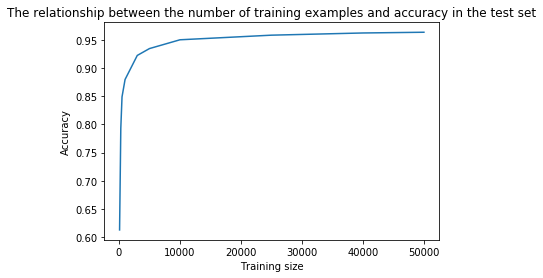

In [22]:
#draw graph
plt.title('The relationship between the number of training examples and accuracy in the test set')
plt.plot(train_size, predict_accuracy)
plt.xlabel('Training size')
plt.ylabel('Accuracy')
plt.show()

From the accuracy result and graph above, we can roughly analyze the relationship between the number of training examples and accuracy in the test set:
1. When K is settled, the larger of the training size is, the higher of the accuracy is.
2. When K is settled, the accuracy grows really fast at the beginning when the training size is very small(smaller than 5000), but with the training size's growing, the accuracy grows slower and slower.

From these findings, we can learn that in order to achieve higher accuracy in machine learning model training, larger training sets are required.

**Part B**: Explore the relationship between the number of nearest neighbors and accuracy on the test set. Comment on your findings and support your observations with some kind of graphic. 

In [20]:
train_size = [10000]
k_size = [1,2,3,4,5,6,7,8,9,10,15,20]
test_size = [2000]
train_set_number, pixels = data.train_x.shape
test_set_number,pixels_test = data.test_x.shape

predict_accuracy = []
for ii in train_size:
    indices = np.random.choice(train_set_number, ii) #randomly select train data
    indices_test = np.random.choice(test_set_number, test_size[0])
    
    train_x = data.train_x[indices, :]
    train_y = data.train_y[indices]
    test_x = data.test_x[indices_test, :]
    test_y = data.test_y[indices_test]
    for k in k_size:
        knn = Knearest(train_x, train_y, k)
        confusion_matrix = knn.confusion_matrix(test_x, test_y)
        result = knn.accuracy(confusion_matrix)
        predict_accuracy.append(result)
        print('When the number of training samples is ', ii , 'and K is', k ,', the accuracy is ', result)
        
        


When the number of training samples is  10000 and K is 1 , the accuracy is  0.9415
When the number of training samples is  10000 and K is 2 , the accuracy is  0.928
When the number of training samples is  10000 and K is 3 , the accuracy is  0.9455
When the number of training samples is  10000 and K is 4 , the accuracy is  0.9345
When the number of training samples is  10000 and K is 5 , the accuracy is  0.9375
When the number of training samples is  10000 and K is 6 , the accuracy is  0.9365
When the number of training samples is  10000 and K is 7 , the accuracy is  0.9405
When the number of training samples is  10000 and K is 8 , the accuracy is  0.935
When the number of training samples is  10000 and K is 9 , the accuracy is  0.939
When the number of training samples is  10000 and K is 10 , the accuracy is  0.935
When the number of training samples is  10000 and K is 15 , the accuracy is  0.932
When the number of training samples is  10000 and K is 20 , the accuracy is  0.925


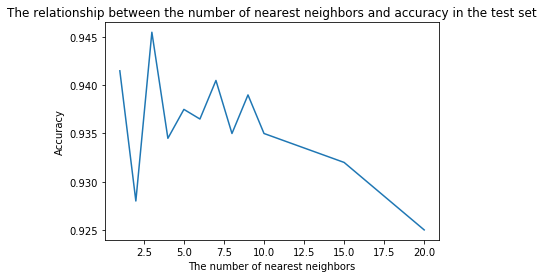

In [21]:
#draw graph
plt.title('The relationship between the number of nearest neighbors and accuracy in the test set')
plt.plot(k_size, predict_accuracy)
plt.xlabel('The number of nearest neighbors')
plt.ylabel('Accuracy')
plt.show()

From the accuracy result and graph above(train size is 10000, test size is 2000, train size: test size = 5:1), we can roughly analyze the relationship between the number of nearest neighbors and accuracy in the test set:
1. From overall view, we can see that with the growing of K, the accuracy gets lower in general.
2. When K is odd number, the accuracy is relatively higher than when K is even number This is probably because when K is even number, there is a higher chance to generate tie cases.
3. When K = 1, there could have the situation of overfitting and the neighbors have not be taken into consideration. K=1 is not appropriate.
4. The choice of K is emperical, we could use cross-validation and grid search method to find the optimal one. In our case, K=3 could probably be the optimal one.



**Part C**: Which numbers get confused with each other the most easily?  Use the confusion_matrix function that you wrote above to support your conclusion.  Then use the `view_digit` function given below to plot a few examples of misclassified digits and discuss possible reasons for the misclassifications.  (Investigating misclassified examples is called **error analysis** and is an important step in the development of any classification technique).  

true label: 5


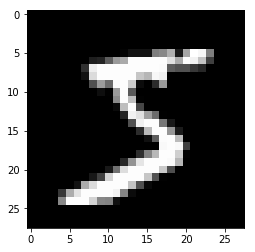

In [23]:
def view_digit(example, label=None):
    if label: print("true label: {:d}".format(label),)
    plt.imshow(example.reshape(28,28), cmap='gray');
    
view_digit(data.train_x[0,:], data.train_y[0])

In [8]:
#calculate Confusion Matrix
#print out error
train_size = [50000]
k_size = [3]
train_set_number, pixels = data.train_x.shape

predict_accuracy = []
for ii in train_size:
    indices = np.random.choice(train_set_number, ii) #randomly select train data
    
    train_x = data.train_x[indices, :]
    train_y = data.train_y[indices]
    for k in k_size:
        knn = Knearest(train_x, train_y, k)
        confusion_matrix = knn.confusion_matrix(data.test_x, data.test_y)
        print("Confusion matrix is:")
        print(confusion_matrix)

index: 5 actual label:  4 predicted label:  9
index: 9 actual label:  4 predicted label:  9
index: 78 actual label:  9 predicted label:  8
index: 86 actual label:  6 predicted label:  2
index: 88 actual label:  9 predicted label:  1
index: 116 actual label:  8 predicted label:  3
index: 120 actual label:  1 predicted label:  4
index: 155 actual label:  5 predicted label:  3
index: 196 actual label:  2 predicted label:  1
index: 239 actual label:  9 predicted label:  0
index: 258 actual label:  8 predicted label:  3
index: 272 actual label:  8 predicted label:  6
index: 317 actual label:  3 predicted label:  8
index: 318 actual label:  9 predicted label:  7
index: 320 actual label:  5 predicted label:  7
index: 329 actual label:  9 predicted label:  7
index: 340 actual label:  3 predicted label:  2
index: 342 actual label:  8 predicted label:  5
index: 346 actual label:  8 predicted label:  7
index: 349 actual label:  9 predicted label:  7
index: 359 actual label:  7 predicted label:  1

index: 4394 actual label:  8 predicted label:  3
index: 4452 actual label:  4 predicted label:  9
index: 4492 actual label:  8 predicted label:  6
index: 4506 actual label:  1 predicted label:  2
index: 4520 actual label:  9 predicted label:  3
index: 4528 actual label:  5 predicted label:  3
index: 4542 actual label:  7 predicted label:  9
index: 4551 actual label:  2 predicted label:  8
index: 4556 actual label:  2 predicted label:  3
index: 4574 actual label:  2 predicted label:  6
index: 4582 actual label:  4 predicted label:  9
index: 4650 actual label:  4 predicted label:  9
index: 4682 actual label:  2 predicted label:  3
index: 4686 actual label:  4 predicted label:  9
index: 4701 actual label:  8 predicted label:  9
index: 4756 actual label:  2 predicted label:  3
index: 4782 actual label:  3 predicted label:  2
index: 4834 actual label:  2 predicted label:  1
index: 4856 actual label:  3 predicted label:  9
index: 4858 actual label:  3 predicted label:  5
index: 4867 actual l

index: 9830 actual label:  7 predicted label:  8
index: 9915 actual label:  4 predicted label:  7
index: 9934 actual label:  0 predicted label:  6
index: 9942 actual label:  9 predicted label:  7
index: 9948 actual label:  9 predicted label:  7
index: 9969 actual label:  9 predicted label:  7
index: 9992 actual label:  9 predicted label:  7
Confusion matrix is:
[[ 980    0    3    0    1    0    5    2    0    0]
 [   0 1059    2    0    1    0    0    1    1    0]
 [   4    7  945    8    0    1    1   18    5    1]
 [   0    0    5  998    0    8    0    4    9    6]
 [   0    9    0    0  943    0    1    4    0   26]
 [   2    2    1   19    2  859   16    3    4    7]
 [   2    1    1    0    0    1  962    0    0    0]
 [   0   12    0    1    2    0    0 1064    1   10]
 [   1    9    2   19    1   14    8    6  937   12]
 [   4    3    0    8   14    6    0   15    3  908]]


Here I print out confusion matrix and all the error cases. The error cases here could be used to locate the error prediction, which will be used in the following problems. The traning size is 50000, test size is 10000

In [9]:
#calculate the miss rate
#print confuion matrix again
print('This is confusion matrix:')
print(confusion_matrix)
list_diagonal = confusion_matrix.diagonal()
sum_CM = np.zeros(10)
miss_rate_list = np.zeros(10)
for jj in range(len(list_diagonal)):
    sum_CM[jj] = sum(confusion_matrix[jj])
for ii in range(len(list_diagonal)):
    miss_rate_list[ii] = (sum_CM[ii]-list_diagonal[ii])/sum_CM[ii]
    print('The miss rate for number', ii, 'is ', miss_rate_list[ii])

This is confusion matrix:
[[ 980    0    3    0    1    0    5    2    0    0]
 [   0 1059    2    0    1    0    0    1    1    0]
 [   4    7  945    8    0    1    1   18    5    1]
 [   0    0    5  998    0    8    0    4    9    6]
 [   0    9    0    0  943    0    1    4    0   26]
 [   2    2    1   19    2  859   16    3    4    7]
 [   2    1    1    0    0    1  962    0    0    0]
 [   0   12    0    1    2    0    0 1064    1   10]
 [   1    9    2   19    1   14    8    6  937   12]
 [   4    3    0    8   14    6    0   15    3  908]]
The miss rate for number 0 is  0.0110998990918
The miss rate for number 1 is  0.0046992481203
The miss rate for number 2 is  0.0454545454545
The miss rate for number 3 is  0.031067961165
The miss rate for number 4 is  0.0406917599186
The miss rate for number 5 is  0.0612021857923
The miss rate for number 6 is  0.00517063081696
The miss rate for number 7 is  0.0238532110092
The miss rate for number 8 is  0.0713577799802
The miss rate for nu

Here I calculate the miss rate for each class. From the result, we can see that number 8(miss rate = 0.071), number 5(miss rate = 0.061) and number 9(miss rate = 0.055) are the top classes with highest miss rate. In this case, number 8,5 and 9 are easiest to get confused with other numbers. So in the following section, I choose 8,5 and 9 to discuss the possible reasons.

predicted label: 5
true label: 8


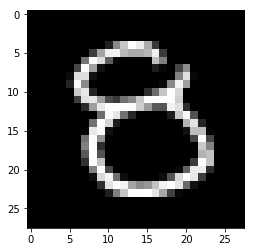

In [24]:
print('predicted label:',5)
view_digit(data.test_x[342,:], data.test_y[342])

In this test case, the model mislabels it as 5 rather than 8. The probable reason here is there is a little bit missing in the upper right corner of this 8 so that it looks like 5 to the model(the average distance the model calculate is shorter to '5' than '8') . In this case, there are more '5' in its neighbors than '8' and it is labeled as '5'.

predicted label: 8
true label: 5


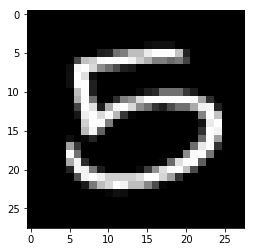

In [25]:
print('predicted label:',8)
view_digit(data.test_x[4002,:], data.test_y[4002])

In this test case, the model mislabels it as 8 rather than 5. The probable reason here is that in the bottom left of this graph, the circle is almost closed, which will make the moel recognize it as the bottom circle of 8. Under this situation, there are more '8' in its neighbors than '5' in terms of the calculated average distanec and it is labeled as '8'.

predicted label: 7
true label: 9


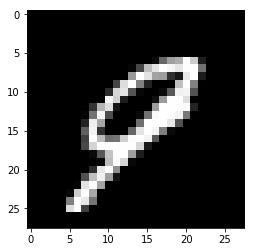

In [21]:
print('predicted label:',7)
view_digit(data.test_x[2127,:], data.test_y[2127])

In this test case, the model mislabels it as 7 rather than 9. The probable reason here is that the upper circle of this '9' has been distorted and model recognizes it as a line. Under this situation, there are more '7' in its neighbors than '9' in terms of the calculated average distanec and it is labeled as '7'.